In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists
#https://docs.python.org/dev/library/pickle.html#module-pickle
import pickle
import re

#https://mahrtayyab.github.io/tweety_docs/twDataTypes.html#media-section
from tweety.bot import Twitter

#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html#geopandas.GeoSeries.distance
from tweety.filters import SearchFilters
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd
import geopy.distance
import geoplot as gplt

#https://github.com/clips/pattern/wiki
import pattern as ptrn
from pattern.web import Twitter as PatternTwitter
from pattern.en import tag
from pattern.vector import KNN, count

#https://www.nltk.org/howto/sentiment.html
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

#https://github.com/RaRe-Technologies/gensim/#documentation
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#https://pypi.org/project/country-converter/
import country_converter as coco
cc = coco.CountryConverter()
import logging
logging.basicConfig(level=None)
coco_logger = coco.logging.getLogger()
coco_logger.setLevel(logging.CRITICAL)

In [2]:
def calc_tweet_place_geography(tweet_place):
    if tweet_place != None:
        if len(tweet_place.coordinates)>1:      
            tweet_place_polygon_coord = Polygon([(loc['latitude'],loc['longitude']) for loc in tweet_place.coordinates])
            tweet_place_centroid_coord = gpd.GeoSeries(tweet_place_polygon_coord).centroid[0]
            tweet_place_coord = tweet_place_centroid_coord.x, tweet_place_centroid_coord.y
            tweet_place_point = tweet_place_centroid_coord
        else:
            tweet_place_point = gpd.points_from_xy([tweet_place.coordinates[0].longitude],[tweet_place.coordinates[0].latitude], z=None, crs=None)[0]
            tweet_place_coord = tweet_place.coordinates[0].latitude, tweet_place.coordinates[0].longitude
        return tweet_place_point, tweet_place_coord
    else:
        tweet_place_coord = None

    

In [3]:
def point_to_coord(point):
    if point.is_empty == False:
        tweet_user_home_coord = (point.y , point.x)
        return tweet_user_home_coord
    else:
        tweet_user_home_coord = None
        return tweet_user_home_coord


In [4]:
def coord_to_point(coord):
    if coord != None:
        long = float('{0:.9f}'.format(coord[1]))
        lat = float('{0:.9f}'.format(coord[0]))
        return gpd.points_from_xy([long],[lat], z=None, crs=None)[0]

In [5]:
def expand_dict_column(df, column_name):
    temp_df = pd.json_normalize(df[column_name], errors='ignore', sep='_', max_level=1).add_prefix(column_name+'_').set_index(df.index)
    return pd.concat([df,temp_df], axis =1)

In [6]:
def extract_df_from_tweet_search(tweet_search):
    start = time.perf_counter()
    #convert tweety search object to pandas df
    raw_df = pd.DataFrame(data =tweet_search.tweets).drop_duplicates(subset = 'id').set_index('id')

    #print(f"Elapsed {(time.perf_counter()-start) }secs.")
    #process geographic parameters
    raw_df['tweet_place_geom'] = raw_df['place'].apply(calc_tweet_place_geography)
    #print(f"Elapsed {(time.perf_counter()-start) }secs.")
    raw_df['tweet_place_point'] = raw_df['tweet_place_geom'].apply(lambda x : x[0] if x != None else None)
    raw_df['tweet_place_coord'] = raw_df['tweet_place_geom'].apply(lambda x : x[1] if x != None else None)
    raw_df['tweet_place_country'] = raw_df['place'].apply(lambda x: x.country if x != None else None)
    raw_df['tweet_place_name'] = raw_df['place'].apply(lambda x: x.full_name if x != None else None)
    raw_df['user_home'] = raw_df['author'].apply(lambda x: x.location)
    #print(len(raw_df))
    raw_df['user_home_geography'] = raw_df['user_home'].apply(lambda x : gpd.tools.geocode(x, provider='arcgis', timeout=None))
    #print(f"Elapsed {(time.perf_counter()-start) }secs.")
    #raw_df.loc[raw_df['user_home']!= None,['user_home_point','user_home_address']] = gpd.tools.geocode(pd.Series(raw_df.loc[raw_df['user_home']!= None,'user_home']), provider='arcgis', timeout=None)
    #print(len(raw_df))
    #print(f"Elapsed {(time.perf_counter()-start) }secs.")
    raw_df['user_home_point'] = raw_df['user_home_geography'].apply(lambda x : x.geometry if isinstance(x, float)==False else None)
    raw_df['user_home_address']= raw_df['user_home_geography'].apply(lambda x : x.address if isinstance(x, float)==False else None)
    #raw_df['user_home_coord'] = raw_df['user_home_point'].apply(lambda x : point_to_coord(x) if isinstance(x, float)==False else None)
   
    raw_df['author'] =raw_df['author'].where(raw_df['author'].notna(), lambda x: [{}])
    raw_df['place'] = raw_df['place'].where(raw_df['place'].notna(), lambda x: [{}])

    raw_df = expand_dict_column(raw_df, 'author')
    raw_df = expand_dict_column(raw_df, 'place')
    return raw_df
    #filter data for available user and tweet locations


In [62]:
def convert_point_string(point_string):
    point_string_cleaned = list(map(float,point_string.replace('(','').replace(')','').split(' ')[1:3]))
    if len(point_string_cleaned)>1:
        #print(point_string_cleaned)
        point_converted = gpd.points_from_xy([point_string_cleaned[0]],[point_string_cleaned[1]])
        #print(point_converted)
        return point_converted[0]
    else:
        return None

## Mine Tweets

In [8]:
app = Twitter()

In [425]:
#users
user_searches = app.search("travelblog -news geocode:39.8283,-95.712891,1500mi",filter_=SearchFilters.Users(),pages = '200')

In [9]:
mavens = pd.DataFrame(user_searches.users)
mavens = mavens[mavens.protected == False]

NameError: name 'user_searches' is not defined

In [12]:
filename_user_df= 'user_df'

if exists(filename_user_df):
    user_df = pd.concat([pd.read_csv(filename_user_df)]).drop_duplicates()
    user_df.to_csv(filename_user_df)
else:
    user_df = mavens
    user_df.to_csv(filename_user_df)
print(len(user_df))



925


In [13]:
filename_user_df= 'user_df'

mavens = pd.read_csv(filename_user_df)
mavens = mavens[mavens.protected == False]

In [14]:
mavens_list = mavens.screen_name

In [ ]:
filename = 'twitter_mave_tweet_data_v3'
written_data = pd.DataFrame(columns = ['author_screen_name'])
if exists(filename):
    written_data = pd.read_csv(filename)
    records_count = len(written_data)
    maven_list_balance = [maven for maven in mavens_list if maven not in list(written_data.author_screen_name)]
else:
    maven_list_balance = mavens_list
    records_count = 0
for maven in maven_list_balance:
    print(maven)
    app = Twitter(maven)
    if maven not in list(list(written_data.author_screen_name)):
        try:
            tweet_search = app.get_tweets(pages = 50)
            if len(tweet_search.tweets)!=0:
                raw_df = extract_df_from_tweet_search(tweet_search).drop('card',axis = 1).reset_index()
                if len(raw_df)>0:
                    if exists(filename):
                        written_data = pd.read_csv(filename)
                        pd.concat([written_data,raw_df]).to_csv(filename)
                    else:
                        raw_df.to_csv(filename)
                    records_count = records_count + len(raw_df)
                    print(raw_df.columns)
        except: 
            None
        print(records_count)

<ipython-input-15-6471221bec02>:4: DtypeWarning: Columns (33,34,36,38,39,40,41,42,43,45,46,52,53,54,55,56,58,59,60,61,66,67,69,71,74,76,77,79,80,81,82,83,238,239,240,241,242,243,244,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,268,269,270,271,276,277,279,281,283,284,286,287,289,290,291,292,293,294,295,296,297,298,299,300) have mixed types. Specify dtype option on import or set low_memory=False.
  written_data = pd.read_csv(filename)


PersnicketyKit
69021
humblebragblog
69021
J3Travelblog
69021
travelblog50
69021
DEN_travelblog
69021
us_travelblog
69021
urbangardens
69021
BadassBackpack
69021
emeraldpalate
69021
familyfocusblog
69021
GLOBE_WATCHERS


/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: Shape

Index(['id', 'created_on', 'author', 'is_retweet', 'is_reply', 'tweet_body',
       'text', 'language', 'likes', 'place', 'retweet_counts', 'source',
       'media', 'user_mentions', 'urls', 'hashtags', 'symbols', 'reply_to',
       'threads', 'comments', 'tweet_place_geom', 'tweet_place_point',
       'tweet_place_coord', 'tweet_place_country', 'tweet_place_name',
       'user_home', 'user_home_geography', 'user_home_point',
       'user_home_address', 'author_id', 'author_rest_id', 'author_created_at',
       'author_default_profile', 'author_default_profile_image',
       'author_description', 'author_fast_followers_count',
       'author_favourites_count', 'author_followers_count',
       'author_friends_count', 'author_has_custom_timelines',
       'author_is_translator', 'author_listed_count', 'author_location',
       'author_media_count', 'author_name', 'author_normal_followers_count',
       'author_profile_banner_url', 'author_profile_image_url_https',
       'author_profile_

<ipython-input-15-6471221bec02>:20: DtypeWarning: Columns (34,35,37,39,40,41,42,43,44,46,47,53,54,55,56,57,59,60,61,62,67,68,70,72,75,77,78,80,81,82,83,84,239,240,241,242,243,244,245,247,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,269,270,271,272,277,278,280,282,284,285,287,288,290,291,292,293,294,295,296,297,298,299,300,301) have mixed types. Specify dtype option on import or set low_memory=False.
  written_data = pd.read_csv(filename)


Index(['id', 'created_on', 'author', 'is_retweet', 'is_reply', 'tweet_body',
       'text', 'language', 'likes', 'place', 'retweet_counts', 'source',
       'media', 'user_mentions', 'urls', 'hashtags', 'symbols', 'reply_to',
       'threads', 'comments', 'tweet_place_geom', 'tweet_place_point',
       'tweet_place_coord', 'tweet_place_country', 'tweet_place_name',
       'user_home', 'user_home_geography', 'user_home_point',
       'user_home_address', 'author_id', 'author_rest_id', 'author_created_at',
       'author_default_profile', 'author_default_profile_image',
       'author_description', 'author_fast_followers_count',
       'author_favourites_count', 'author_followers_count',
       'author_friends_count', 'author_has_custom_timelines',
       'author_is_translator', 'author_listed_count', 'author_location',
       'author_media_count', 'author_name', 'author_normal_followers_count',
       'author_profile_banner_url', 'author_profile_image_url_https',
       'author_profile_

#### Read Data

In [185]:
load_data = pd.concat([pd.read_csv('twitter_mave_tweet_data_v3',dtype='string'),pd.read_csv('twitter_trip_data',dtype='string')])

In [186]:
maven_data_load_filter = load_data.loc[:,~load_data.columns.str.contains('Unnamed', case=False)]
maven_data_load_antifilter = load_data.loc[:,load_data.columns.str.contains('Unnamed', case=False)]
maven_data_load_filter = maven_data_load_filter.drop_duplicates()

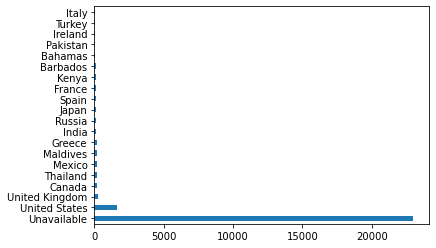

In [187]:
country_dist_unavailable = maven_data_load_filter.fillna('Unavailable')['place_country'].value_counts()[:20].plot(kind='barh').get_figure()
country_dist_unavailable.savefig('country_dist_unavailable')

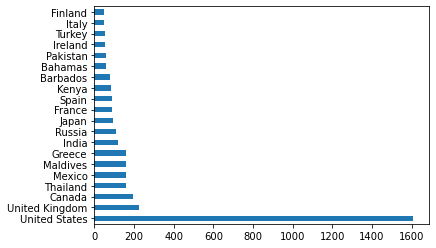

In [188]:
country_dist = maven_data_load_filter['place_country'].value_counts()[:20].plot(kind='barh').get_figure()
country_dist.savefig('country_dist')

In [189]:
print(list(maven_data_load_filter.author_screen_name.unique()))

['flannelsorflip1', 'LGSomewhereMcK', 'doyoudaretoday', 'DiaryofDi', 'fouraroundworld', 'letsdiscoverON', 'travellingsocio', 'lux_tribe', 'AdvMATravel', 'wanderingnorth', 'holidaytravelz', 'TheBelleVoyage', 'MissLoneStar1', 'kreeeeete', 'NoMasCoach', 'TravelPleaseTB', 'wowplacesde', 'LivingLesh', 'smtownplussize', 'travelblog007', 'katsheets', 'Mycaraibes', 'letsgettripsy', 'AdventuresLikeU', 'travelblogUSA', 'DR_travelblog', 'w2travelblog', 'travelblog_', 'TravelTweaks', 'BrinkoftheWorld', 'meedristravel', 'AatEblog', 'amelochevoyage', 'LTravelblog', 'ExploringFL', 'Travelb26404033', 'travelblog30', 'comusetravels', 'ecoecomikesv', 'RightLostTravel', 'no_mad_land', 'lattesnluggage', 'LiveFunTravel', 'WannaSeeItAll', 'Away4mHome', 'ensquaredaired', 'yTravelBlog', 'TravelBlogTBTW', 'astablog_jsn', 'BuzzTravelBlog', 'TravelMamas', 'otavTravelBlog', 'TravelLoveFash', 'travelnursing', 'FamTravelGuide', 'sheriannekay', 'TravelBoldly', 'TwavelTweeter', 'ibeantravelling', 'crankyflier', 'thep

In [190]:
maven_data_load_filter.columns

Index(['id', 'created_on', 'author', 'is_retweet', 'is_reply', 'tweet_body',
       'text', 'language', 'likes', 'place', 'retweet_counts', 'source',
       'media', 'user_mentions', 'urls', 'hashtags', 'symbols', 'reply_to',
       'threads', 'comments', 'tweet_place_geom', 'tweet_place_point',
       'tweet_place_coord', 'tweet_place_country', 'tweet_place_name',
       'user_home', 'user_home_geography', 'user_home_point',
       'user_home_address', 'author_id', 'author_rest_id', 'author_created_at',
       'author_default_profile', 'author_default_profile_image',
       'author_description', 'author_fast_followers_count',
       'author_favourites_count', 'author_followers_count',
       'author_friends_count', 'author_has_custom_timelines',
       'author_is_translator', 'author_listed_count', 'author_location',
       'author_media_count', 'author_name', 'author_normal_followers_count',
       'author_profile_banner_url', 'author_profile_image_url_https',
       'author_profile_

#### Graph Geo

In [191]:
raw_df_loc_data_filter = (maven_data_load_filter['tweet_place_point'].isnull() == False) & (maven_data_load_filter['user_home_point'].isnull() == False)

/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
<ipython-input-193-ba2f3e0fda59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_data['tweet_place_point'] = gpd.GeoSeries(trip_data['tweet_place_point'].apply(convert_point_string))
/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vector

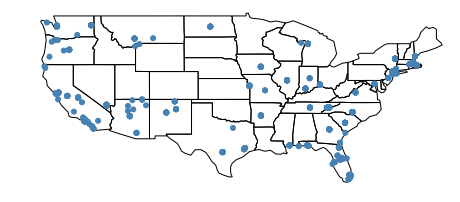

In [193]:
trip_data = maven_data_load_filter[raw_df_loc_data_filter]
trip_data['tweet_place_point'] = gpd.GeoSeries(trip_data['tweet_place_point'].apply(convert_point_string))
trip_data['user_home_point'] = gpd.GeoSeries(trip_data['user_home_point'].apply(convert_point_string))
trip_data['place_country_standardized'] = cc.convert(names = trip_data['place_country'], to ='name')
trip_data['place_country_code_iso3'] = cc.convert(names = trip_data['place_country_code'], to ='ISO3')
trip_data_select_columns = ['id', 'author_id','created_on',
       'text','user_home','user_home_address','place_full_name','user_home_point', 'tweet_place_point','tweet_place_geom',  'place_country_standardized',
       'place_country_code_iso3']
trip_data_select = trip_data[trip_data_select_columns]
trip_data_select.to_csv('trip_data_select')
trip_data_select_usa = trip_data_select[trip_data_select.place_country_standardized == 'United States']
trip_data_select_usa_geometry = gpd.GeoDataFrame(trip_data_select_usa.tweet_place_point.rename('geometry'))
us_map = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
us_geom = us_map.loc[:, 'geometry']
trip_data_select_usa_geometry.crs = us_map.crs
ax = gplt.polyplot(us_map, figsize=(8, 4))
geo =  trip_data_select_usa_geometry
geo = gpd.sjoin(geo,us_map, how="inner")
maven_trip_sample = geoplot.pointplot(geo, ax=ax).get_figure()
maven_trip_sample.savefig('maven_trip_sample')

In [198]:
place_groups = pd.read_csv('place_groups')

In [203]:
place_groups = place_groups[['place_full_name','group']]

/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
<ipython-input-217-4c8e36e04ab8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_data['tweet_place_point'] = gpd.GeoSeries(trip_data['tweet_place_point'].apply(convert_point_string))
/Users/mustafatelab/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vector

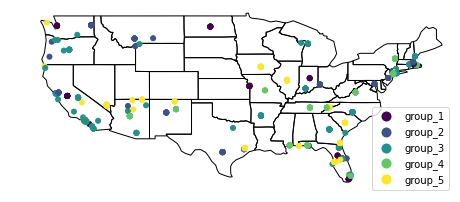

In [217]:
trip_data = maven_data_load_filter[raw_df_loc_data_filter]
trip_data['tweet_place_point'] = gpd.GeoSeries(trip_data['tweet_place_point'].apply(convert_point_string))
trip_data['user_home_point'] = gpd.GeoSeries(trip_data['user_home_point'].apply(convert_point_string))
trip_data['place_country_standardized'] = cc.convert(names = trip_data['place_country'], to ='name')
trip_data['place_country_code_iso3'] = cc.convert(names = trip_data['place_country_code'], to ='ISO3')
trip_data_select_columns = ['id', 'author_id','created_on',
       'text','user_home','user_home_address','place_full_name','user_home_point', 'tweet_place_point','tweet_place_geom',  'place_country_standardized',
       'place_country_code_iso3']
trip_data_select = trip_data[trip_data_select_columns]
trip_data_select.to_csv('trip_data_select')
trip_data_select_usa = trip_data_select[trip_data_select.place_country_standardized == 'United States']
trip_data_select_usa = trip_data_select_usa.merge(place_groups, on = 'place_full_name', how = 'left')
trip_data_select_usa_geometry = gpd.GeoDataFrame(trip_data_select_usa[['tweet_place_point','place_full_name','group']])
trip_data_select_usa_geometry.columns = ['geometry','place_full_name','group']
us_map = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
us_geom = us_map.loc[:, 'geometry']
trip_data_select_usa_geometry.crs = us_map.crs
ax = gplt.polyplot(us_map, figsize=(8, 4))
geo =  trip_data_select_usa_geometry
geo = gpd.sjoin(geo,us_map, how="inner")
maven_trip_sample = geoplot.pointplot(geo, ax=ax,hue='group',legend=True).get_figure()
maven_trip_sample.savefig('maven_trip_sample_grouped')